<a href="https://colab.research.google.com/github/Dembelinho/LSTM_TimeSeries/blob/main/timeSeries_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/test_set/elecdemand_dataset.tsf.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step 0: Explore the dataset**

In [ ]:
# Reading the values into a DataFrame
df = pd.read_csv(file_path, header=None)

# Transposing the DataFrame to have a single row
df = df.T

# Rename the first column from its current name to a new name
df.rename(columns={0: 'values'}, inplace=True)

# Displaying the resulting DataFrame
print(df)

         values
0      3.914647
1      3.672550
2      3.497539
3      3.339145
4      3.204313
...         ...
17515  3.724836
17516  3.761887
17517  3.809415
17518  4.135946
17519  4.217047

[17520 rows x 1 columns]


In [ ]:
# Créez une séquence de dates pour toutes les 30 minutes de l'année 2014
date_range = pd.date_range(start="2014-01-01", end="2014-12-31 23:59:59", freq="30min")

# Ajoutez la séquence de dates comme une nouvelle colonne 'DateTime' dans le DataFrame
df['DateTime'] = date_range

# Définir la colonne 'colonne_a' comme index
df = df.set_index('DateTime')

print(df)

                       values
DateTime                     
2014-01-01 00:00:00  3.914647
2014-01-01 00:30:00  3.672550
2014-01-01 01:00:00  3.497539
2014-01-01 01:30:00  3.339145
2014-01-01 02:00:00  3.204313
...                       ...
2014-12-31 21:30:00  3.724836
2014-12-31 22:00:00  3.761887
2014-12-31 22:30:00  3.809415
2014-12-31 23:00:00  4.135946
2014-12-31 23:30:00  4.217047

[17520 rows x 1 columns]


In [ ]:
print(df.dtypes)

# get the number of missing data points per column
missing_values_count = df.isnull().sum()

missing_values_count

values    float64
dtype: object


values    0
dtype: int64

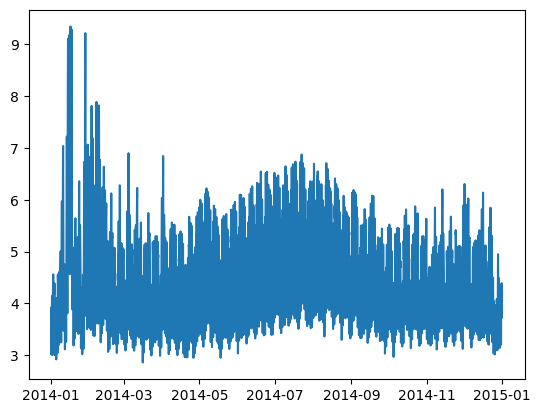

In [ ]:
plt.plot(df['values'])

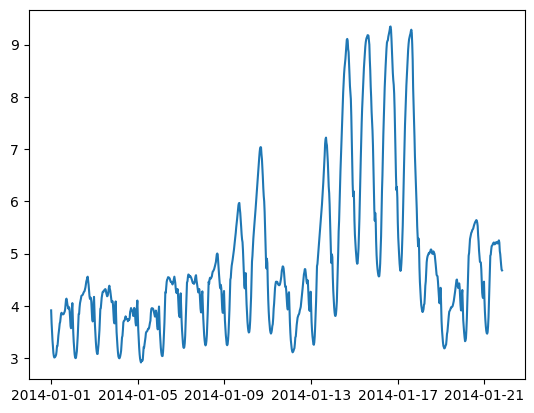

In [ ]:
df_subset = df.iloc[:1000]

# Tracer les données
plt.plot(df_subset['values'])

# Afficher le graphique
plt.show()

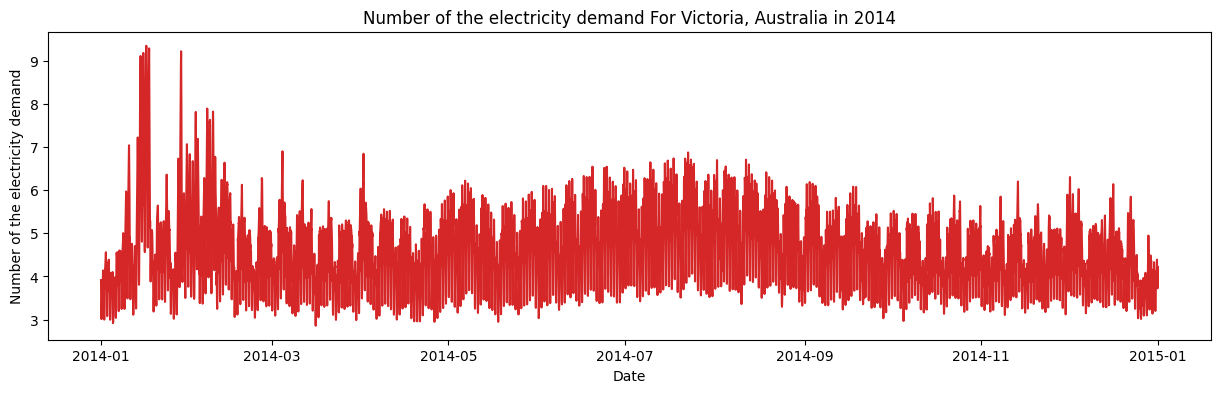

In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of the electricity demand', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df['values'], title='Number of the electricity demand For Victoria, Australia in 2014')

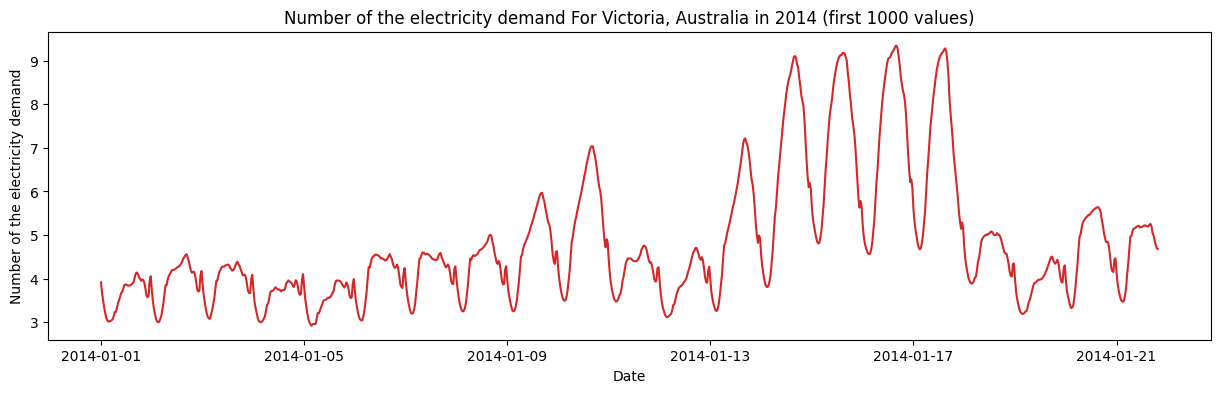

In [ ]:
plot_df(df_subset, x=df_subset.index, y=df_subset['values'], title='Number of the electricity demand For Victoria, Australia in 2014 (first 1000 values)')

# **Step 1: Check for stationarity of time series**

In [ ]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df['values'])
#print("pvalue = ", pvalue, " if above 0.05, data is not stationary")

if(pvalue > 0.05):
    print("data is not stationary with pvalue = ",pvalue)
else :
    print("data is stationary with pvalue = ",pvalue)


data is stationary with pvalue =  0.0005510194996223703


In [ ]:
#kpss_stat, p_value, lags, critical_values = kpss(df['values'])
kpss_stat, p_value, lags, critical_values = kpss(df['values'], nlags='legacy')


if p_value < 0.05:
    print("The KPSS test rejects the null hypothesis. This means that the time series is not stationary with respect to the trend. with pvalue = ",pvalue)
else:
    print("The KPSS test does not reject the null hypothesis. This implies that the time series is stationary with respect to the trend. with pvalue = ",pvalue)

The KPSS test rejects the null hypothesis. This means that the time series is not stationary with respect to the trend. with pvalue =  0.0005510194996223703


<ipython-input-418-4211b71e0d25>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(df['values'], nlags='legacy')


In [ ]:
#la décomposition saisonnière additive sur la série temporelle
decompose = seasonal_decompose(df['values'], model='additive',period=30)

trend_subset = decompose.trend.iloc[:1000]
seasonal_subset = decompose.seasonal.iloc[:1000]
residual_subset = decompose.resid.iloc[:1000]

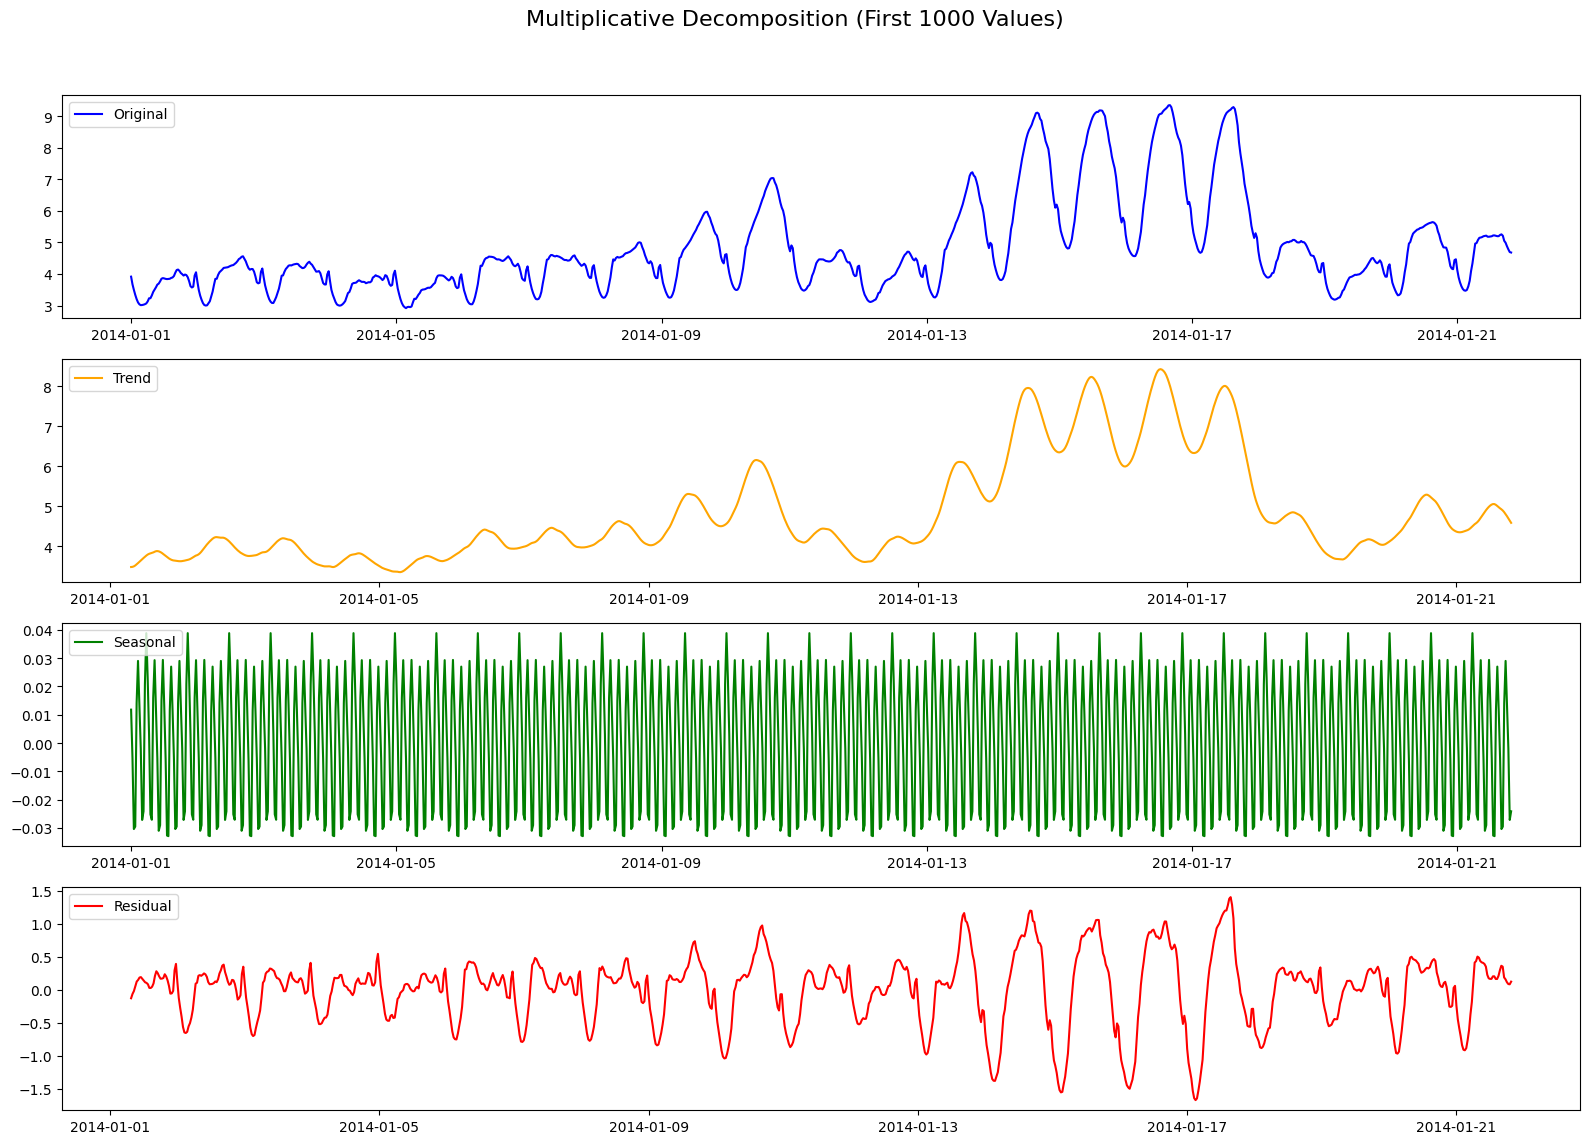

In [ ]:
# Create subplots for each component
plt.figure(figsize=(16, 12))

# Plot the original time series
plt.subplot(411)
plt.plot(df['values'].iloc[:1000], label='Original', color='blue')
plt.legend(loc='upper left')

# Plot the trend component
plt.subplot(412)
plt.plot(trend_subset, label='Trend', color='orange')
plt.legend(loc='upper left')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal_subset, label='Seasonal', color='green')
plt.legend(loc='upper left')

# Plot the residual component
plt.subplot(414)
plt.plot(residual_subset, label='Residual', color='red')
plt.legend(loc='upper left')

# Add a super title
plt.suptitle('Multiplicative Decomposition (First 1000 Values)', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

**Transform to stationary: differencing**

In [ ]:
diff_order = 1

df["values_diff"] = df["values"] - df["values"].shift(diff_order)

df

,values,values_diff
DateTime,,
2014-01-01 00:00:00,3.914647,NaN
2014-01-01 00:30:00,3.672550,-0.242098
2014-01-01 01:00:00,3.497539,-0.175011
2014-01-01 01:30:00,3.339145,-0.158394
2014-01-01 02:00:00,3.204313,-0.134832
...,...,...
2014-12-31 21:30:00,3.724836,-0.066802
2014-12-31 22:00:00,3.761887,0.037051
2014-12-31 22:30:00,3.809415,0.047528


In [ ]:
new_df = pd.DataFrame(df[1:]['values_diff'] , index=df[1:].index)
new_df.columns=['values_diff']
new_df

,values_diff
DateTime,
2014-01-01 00:30:00,-0.242098
2014-01-01 01:00:00,-0.175011
2014-01-01 01:30:00,-0.158394
2014-01-01 02:00:00,-0.134832
2014-01-01 02:30:00,-0.104270
...,...
2014-12-31 21:30:00,-0.066802
2014-12-31 22:00:00,0.037051
2014-12-31 22:30:00,0.047528


<Axes: xlabel='DateTime'>

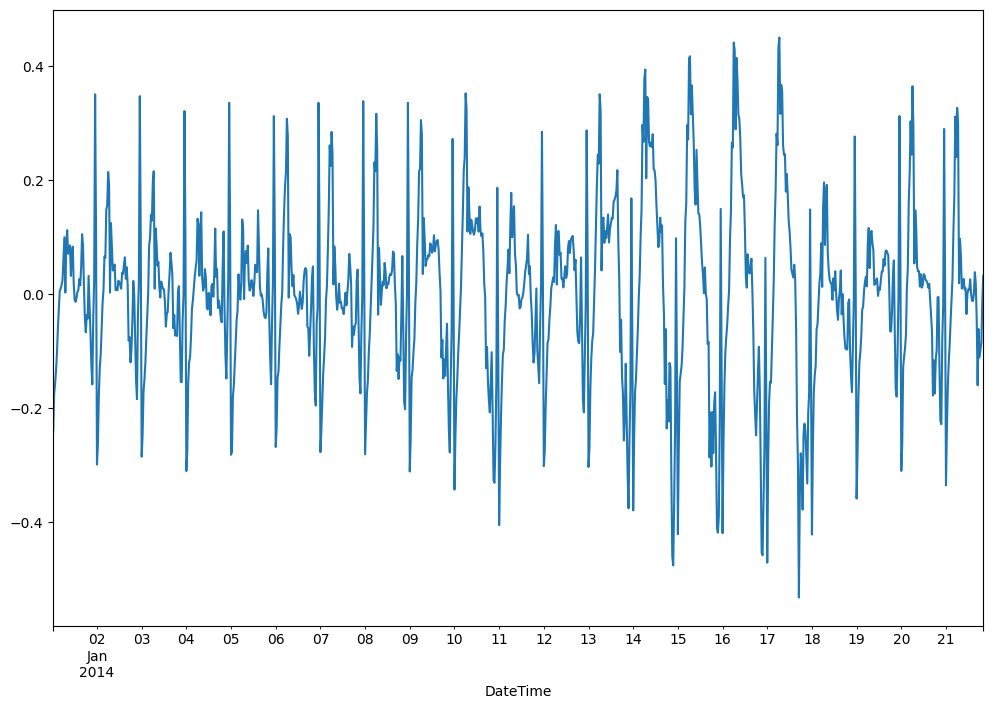

In [ ]:
new_df["values_diff"].iloc[:1000].plot(figsize=(12, 8))

In [ ]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(new_df['values_diff'])

if(pvalue > 0.05):
    print("data is not stationary with pvalue = ",pvalue)
else :
    print("data is stationary with pvalue = ",pvalue)

data is stationary with pvalue =  0.0


In [ ]:
kpss_stat, p_value, lags, critical_values = kpss(new_df['values_diff'], nlags='legacy')


if p_value < 0.05:
    print("The KPSS test rejects the null hypothesis. This means that the time series is not stationary with respect to the trend.")
else:
    print("The KPSS test does not reject the null hypothesis. This implies that the time series is stationary with respect to the trend.")

The KPSS test does not reject the null hypothesis. This implies that the time series is stationary with respect to the trend.


<ipython-input-425-8fed4fbf339d>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(new_df['values_diff'], nlags='legacy')


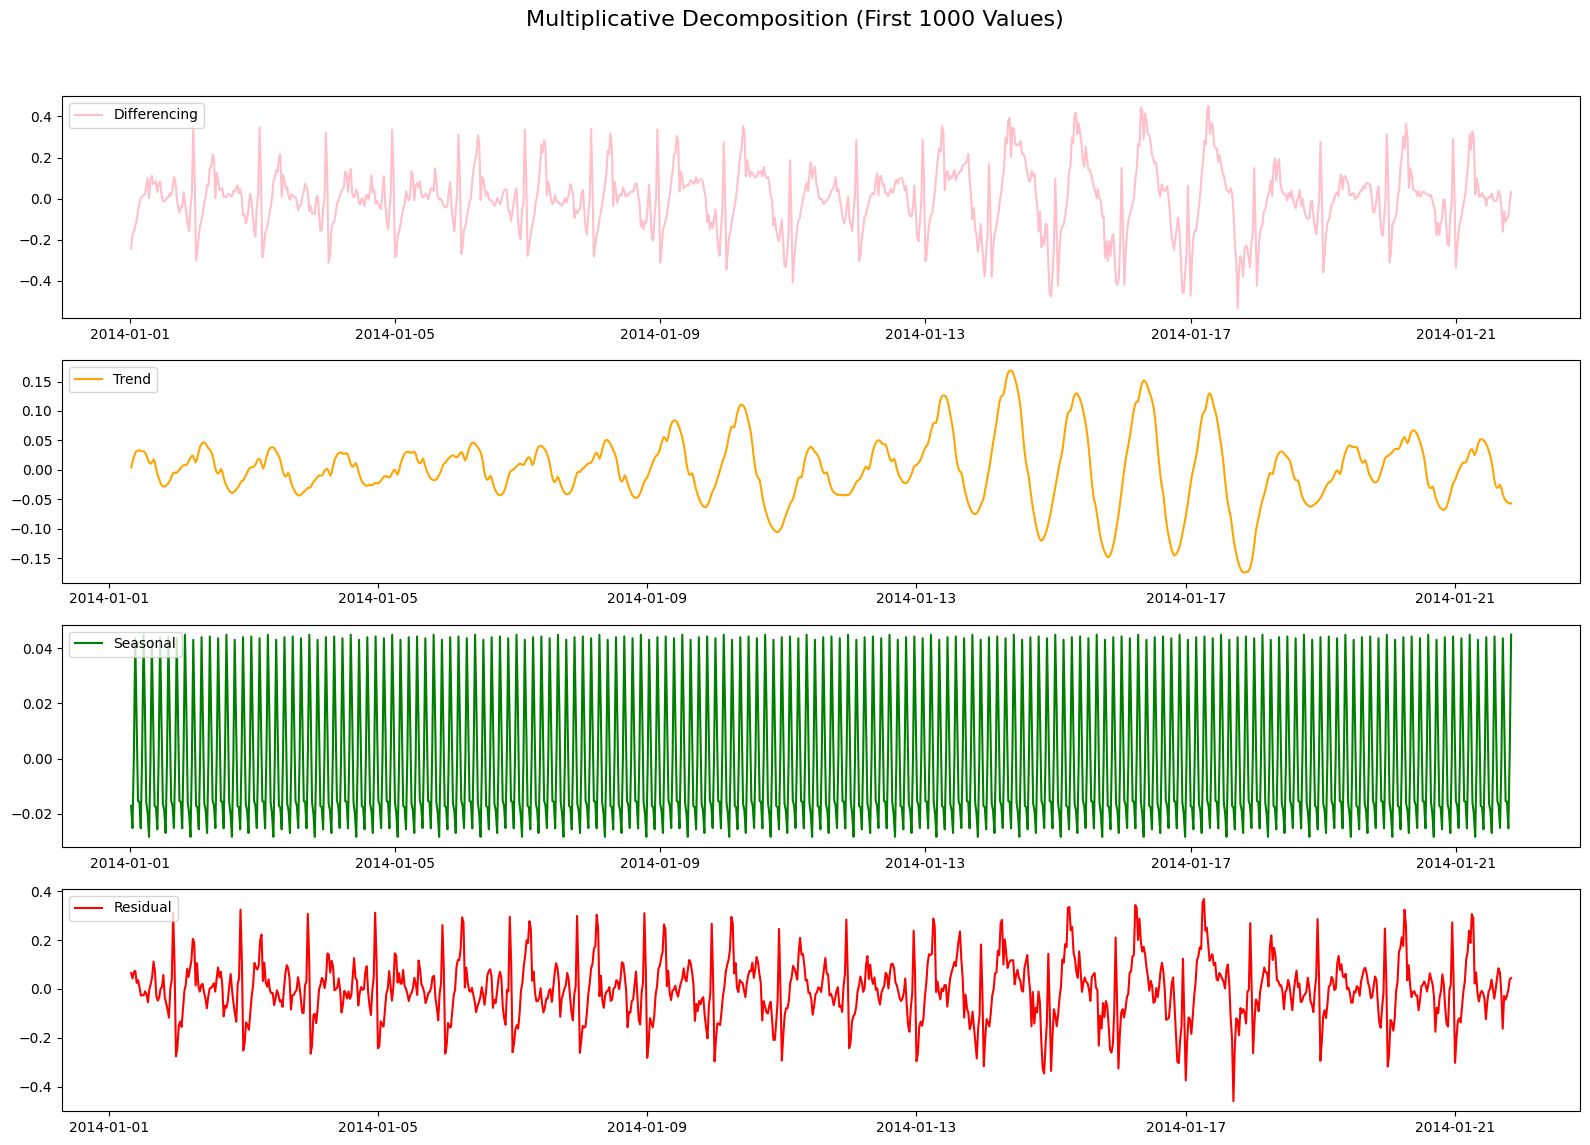

In [ ]:
decompose = seasonal_decompose(new_df['values_diff'], model='additive',period=30)

trend_subset = decompose.trend.iloc[:1000]
seasonal_subset = decompose.seasonal.iloc[:1000]
residual_subset = decompose.resid.iloc[:1000]

plt.figure(figsize=(16, 12))

# Plot the original time series
plt.subplot(411)
plt.plot(new_df['values_diff'].iloc[:1000], label='Differencing', color='pink')
plt.legend(loc='upper left')

# Plot the trend component
plt.subplot(412)
plt.plot(trend_subset, label='Trend', color='orange')
plt.legend(loc='upper left')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal_subset, label='Seasonal', color='green')
plt.legend(loc='upper left')

# Plot the residual component
plt.subplot(414)
plt.plot(residual_subset, label='Residual', color='red')
plt.legend(loc='upper left')

# Add a super title
plt.suptitle('Multiplicative Decomposition (First 1000 Values)', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()



# ***1.   ARIMA | AUTO-ARIMA MODEL***



# **Step 2: Determine ARIMA models parameters p, q**



In [ ]:
# split into train and test sets
size = int(len(new_df) * 0.66)
train, test = new_df[0:size], new_df[size:len(new_df)]


In [ ]:
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# **Step 3: Fit the ARIMA model**

In [ ]:
# Ajuster le modèle ARIMA sur l'ensemble d'entraînement
model = ARIMA(train, order=(3, 0, 2))
model_fit = model.fit()

print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            values_diff   No. Observations:                11562
Model:                 ARIMA(3, 0, 2)   Log Likelihood               11125.211
Date:                Thu, 08 Feb 2024   AIC                         -22236.422
Time:                        15:49:01   BIC                         -22184.934
Sample:                    01-01-2014   HQIC                        -22219.119
                         - 08-29-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.656e-05      0.001      0.188      0.851      -0.001       0.001
ar.L1          1.0311      0.007    139.006      0.000       1.017       1.046
ar.L2          0.4593      0.013     35.035      0.0

# **Step 4: Make time series predictions**

In [ ]:
output = model_fit.forecast(len(test))

#output

In [ ]:
forecast_test_autoArima = auto_arima.predict(n_periods=len(test))

In [ ]:
# Créer un DataFrame à partir des prévisions et les vraies valeurs
predictions = pd.DataFrame({'Actual': test['values_diff'],'ARIMA predicted': output, 'AUTO-ARIMA predicted': forecast_test_autoArima }, index=test.index)

predictions


,Actual,ARIMA predicted,AUTO-ARIMA predicted
DateTime,,,
2014-08-29 21:30:00,-0.189195,-0.170377,-1.700539e-01
2014-08-29 22:00:00,-0.145108,-0.113132,-1.130603e-01
2014-08-29 22:30:00,-0.108716,-0.095064,-9.484397e-02
2014-08-29 23:00:00,0.222256,-0.056970,-5.726021e-02
2014-08-29 23:30:00,-0.006625,-0.040643,-4.095701e-02
...,...,...,...
2014-12-31 21:30:00,-0.066802,0.000097,9.881313e-324
2014-12-31 22:00:00,0.037051,0.000097,9.881313e-324
2014-12-31 22:30:00,0.047528,0.000097,9.881313e-324


<ipython-input-433-01e53e1cc114>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(predictions['Actual'][:100], 'r', label="true" , color='green')
<ipython-input-433-01e53e1cc114>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(predictions['ARIMA predicted'][:100], 'r', label="ARIMA prediction" , color='red')
<ipython-input-433-01e53e1cc114>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(predictions['AUTO-ARIMA predicted'][:100], 'r', label="AUTO-ARIMA predicted" , color='orange')


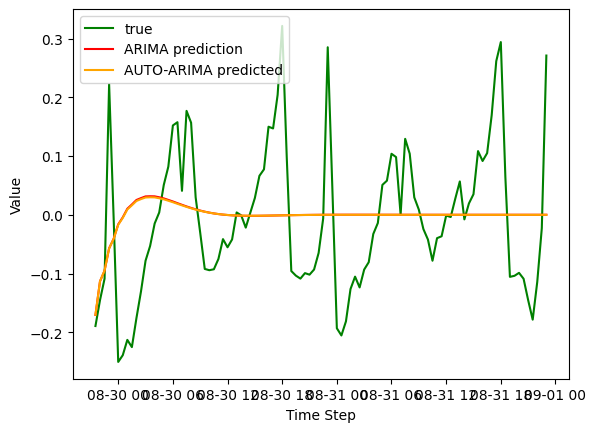

In [ ]:
plt.plot(predictions['Actual'][:100], 'r', label="true" , color='green')
plt.plot(predictions['ARIMA predicted'][:100], 'r', label="ARIMA prediction" , color='red')
plt.plot(predictions['AUTO-ARIMA predicted'][:100], 'r', label="AUTO-ARIMA predicted" , color='orange')
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# **Step 5: Evaluate model predictions**



In [ ]:
def calculate_accuracy(y_true, y_pred, threshold):
    correct_predictions = 0
    total_predictions = len(y_true)
    for i in range(total_predictions):
        if abs(y_true[i] - y_pred[i]) <= threshold:
            correct_predictions += 1
    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
# Définir le seuil de tolérance
threshold = 0.1  # Par exemple, considérer toute prédiction à moins de 0.1 unité de la vraie valeur comme correcte

# Calculer l'erreur moyen absolue (MAE)
mae = np.mean(np.abs(predictions['Actual'] - predictions['ARIMA predicted']))
corr = np.corrcoef(predictions['Actual'] , predictions['ARIMA predicted'])[0,1]
mse = np.mean((predictions['Actual'] - predictions['ARIMA predicted'])**2)
rmse = np.sqrt(mse)
accuracy = calculate_accuracy(predictions['Actual'], predictions['ARIMA predicted'], threshold)

print("Accuracy:", accuracy)
print("Mean Absolute Error (MAE):", mae)
print("Correlation:", corr)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Accuracy: 0.6150747020312237
Mean Absolute Error (MAE): 0.09902240418595501
Correlation: 0.017425288967291338
Mean Squared Error (MSE): 0.0179269207228323
Root Mean Squared Error (RMSE): 0.13389145126867621




# ***2.   LSTM MODEL***



In [ ]:
df.drop(columns=['values_diff'], inplace=True)
df

,values
DateTime,
2014-01-01 00:00:00,3.914647
2014-01-01 00:30:00,3.672550
2014-01-01 01:00:00,3.497539
2014-01-01 01:30:00,3.339145
2014-01-01 02:00:00,3.204313
...,...
2014-12-31 21:30:00,3.724836
2014-12-31 22:00:00,3.761887
2014-12-31 22:30:00,3.809415


# **Step 2: Data Preparation**

In [ ]:
#Convert pandas dataframe to numpy array
dataset = df.values
dataset = dataset.astype('float32') #COnvert values to float

# normalize the dataset using MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#dataset

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#test

In [ ]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])

    return np.array(x),np.array(y)


seq_size = 3 # Number of time steps to look back
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [ ]:
# summarize the data
for i in range (10):
 print(trainX[i], trainY[i])

[0.16289374 0.12557372 0.09859529] 0.07417831
[0.12557372 0.09859529 0.07417831] 0.053393513
[0.09859529 0.07417831 0.05339351] 0.037319988
[0.07417831 0.05339351 0.03731999] 0.027982146
[0.05339351 0.03731999 0.02798215] 0.0237616
[0.03731999 0.02798215 0.0237616 ] 0.024560392
[0.02798215 0.0237616  0.02456039] 0.02600962
[0.0237616  0.02456039 0.02600962] 0.028460562
[0.02456039 0.02600962 0.02846056] 0.03220263
[0.02600962 0.02846056 0.03220263] 0.04193899


# **Step 3: Fit the LSTM model**

In [ ]:
n_features = 1
n_steps = seq_size

# define model
model = Sequential()
#model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics = ['acc'])

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 3, 50)             10400     
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))

# fit model
history = model.fit(trainX, trainY, epochs=100, verbose=0)

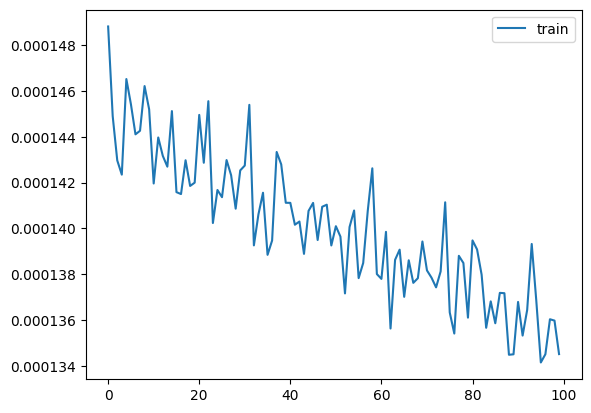

In [ ]:
plt.plot(history.history['loss'], label='train')

plt.legend();

# **Step 4: Make time series predictions**

In [ ]:
#prediction data
testX = testX.reshape((testX.shape[0], testX.shape[1], n_features))

y_predicted = model.predict(testX, verbose=0)

print(y_predicted)

[[0.2601452 ]
 [0.30281952]
 [0.27344772]
 ...
 [0.13169965]
 [0.1572836 ]
 [0.15872636]]


In [ ]:
testY

array([0.29902175, 0.29800048, 0.25942066, ..., 0.13934532, 0.14667186,
       0.19700763], dtype=float32)

<ipython-input-446-1e9b18846b88>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(testY[:100], 'r', label="true" , color='green')
<ipython-input-446-1e9b18846b88>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(y_predicted[:100], 'r', label="prediction" , color='red')


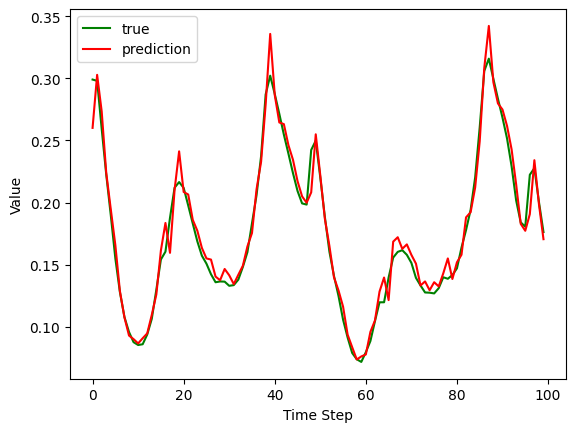

In [ ]:
plt.plot(testY[:100], 'r', label="true" , color='green')
plt.plot(y_predicted[:100], 'r', label="prediction" , color='red')
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# **Step 5: Evaluate model predictions**


In [ ]:
# Calculer l'erreur moyen absolue (MAE)
mae = np.mean(np.abs(testY - y_predicted))
mse = np.mean((testY - y_predicted)**2)
rmse = np.sqrt(mse)# Afficher le MAE

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.11884197
Mean Squared Error (MSE): 0.021450274
Root Mean Squared Error (RMSE): 0.14645912


In [ ]:
accuracy = calculate_accuracy(testY, y_predicted, threshold)

print("Accuracy:", accuracy)


Accuracy: 1.0
